# Visualizing Separation Analysis

**Gregory Way 2019**

Visualizing GTEx Sex and TARGET MYCN Status Features

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))

In [2]:
# Store t test results and identify top features
t_test_results_files <- list.files("results", full.names = TRUE)
t_test_results_files <- t_test_results_files[grepl('t_test', t_test_results_files)]
t_test_results_files

[1] "results/nbl_mycn_separation_target_t_test.tsv"
[2] "results/sex_separation_gtex_t_test.tsv"       
[3] "results/sex_separation_tcga_t_test.tsv"

In [3]:
# Store t test results and identify top features
best_result_list <- list()
line_gg_list <- list()
for (t_test_file in t_test_results_files) {
  full_results_df <- readr::read_tsv(t_test_file,
                                     col_types = readr::cols(
                                       t_stat = readr::col_double(),
                                       t_p = readr::col_double(),
                                       algorithm = readr::col_character(),
                                       feature_num = readr::col_double(),
                                       z_dim = readr::col_double(),
                                       signal = readr::col_character(),
                                       seed = readr::col_double(),
                                       neg_log_p = readr::col_double()
                                       )
                                     )
  
  top_results_df <- full_results_df %>%
    dplyr::group_by(algorithm, z_dim, signal) %>%
    dplyr::filter(neg_log_p == max(neg_log_p),
                  signal == "signal")
  
  # Create factors for plotting
  top_results_df$z_dim <-
    factor(top_results_df$z_dim,
           levels =
             sort(as.numeric(paste(unique(top_results_df$z_dim))))
    )
  
  top_results_df$algorithm <-
    factor(top_results_df$algorithm,
           levels = c("pca", "ica", "nmf", "dae", "vae"))
  
  panel_gg <- ggplot(top_results_df,
                       aes(x = z_dim,
                           y = neg_log_p,
                           color = algorithm,
                           group = algorithm)) +
    geom_smooth(aes(fill = algorithm),
                lwd = 0.3,
                alpha = 0.4,
                method = 'loess',
                formula = 'y ~ x') +
    geom_point(size = 0.5) +
    scale_color_manual(name = "Algorithm",
                       values = c("#e41a1c",
                                  "#377eb8",
                                  "#4daf4a",
                                  "#984ea3",
                                  "#ff7f00"),
                       labels = c("pca" = "PCA",
                                  "ica" = "ICA",
                                  "nmf" = "NMF",
                                  "dae" = "DAE",
                                  "vae" = "VAE")) +
    scale_fill_manual(name = "Algorithm",
                      values = c("#e41a1c",
                                 "#377eb8",
                                 "#4daf4a",
                                 "#984ea3",
                                 "#ff7f00"),
                      labels = c("pca" = "PCA",
                                 "ica" = "ICA",
                                 "nmf" = "NMF",
                                 "dae" = "DAE",
                                 "vae" = "VAE")) +
    theme_bw() +
    ylab("-log10 P Value") +
    xlab("k Dimensions") +
    theme(axis.title.x = element_text(size = 7),
          axis.title.y = element_text(size = 7),
          axis.text.x = element_text(angle = 90,
                                     size = 5),
          axis.text.y = element_text(size = 6),
          plot.title = element_text(size = 8,
                                    hjust = 0.5),
          legend.text = element_text(size = 5),
          legend.title = element_text(size = 6),
          legend.key.size = unit(0.4, "lines"))
  
  
  best_result_df <- top_results_df %>%
    dplyr::arrange(desc(neg_log_p)) %>%
    dplyr::ungroup() %>%
    dplyr::top_n(n = 1, wt = neg_log_p)
  
  best_result_list[[t_test_file]] <- best_result_df
  line_gg_list[[t_test_file]] <- panel_gg
}

## Plot GTEx Sex Example

In [4]:
file <- file.path("..", "0.expression-download", "download", "GTEx_v7_Annotations_SubjectPhenotypesDS.txt")
gtex_pheno_df <- readr::read_tsv(file)

Parsed with column specification:
cols(
  SUBJID = col_character(),
  SEX = col_integer(),
  AGE = col_character(),
  DTHHRDY = col_integer()
)


In [5]:
best_k_dim <- paste(best_result_list[[t_test_results_files[2]]]$z_dim)
best_seed <- paste(best_result_list[[t_test_results_files[2]]]$seed)
best_feature <- paste0(paste(best_result_list[[t_test_results_files[2]]]$algorithm),
                       "_", 
                       paste(best_result_list[[t_test_results_files[2]]]$feature_num))

In [6]:
print(best_k_dim)
print(best_seed)
print(best_feature)

[1] "200"
[1] "486191"
[1] "vae_108"


In [7]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "GTEX_results",
                          "ensemble_z_matrices",
                          paste0("gtex_components_", best_k_dim),
                          paste0("model_", best_seed, "_z_matrix.tsv.gz"))

top_feature_df <- readr::read_tsv(feature_file,
                                  col_types = readr::cols(
                                    .default = readr::col_double(),
                                    sample_id = readr::col_character()
                                  )
) %>%
  dplyr::select(sample_id, !!best_feature)

In [8]:
full_gtex_ids <- c()
for (gtex_id in strsplit(top_feature_df$sample_id, "-")) {
  gtex_id_unlist <- unlist(gtex_id)
  sample_id <- paste0(gtex_id_unlist[1], "-", gtex_id_unlist[2])
  full_gtex_ids <- c(full_gtex_ids, sample_id)
}

top_feature_df$gtex_id <- full_gtex_ids
top_feature_df <- top_feature_df %>%
  dplyr::left_join(gtex_pheno_df, by = c("gtex_id" = "SUBJID"))

top_feature_df$SEX <- dplyr::recode_factor(top_feature_df$SEX, `1` = "Male", `2` = "Female")
top_feature_df$SEX <- factor(top_feature_df$SEX, levels = c("Female", "Male"))

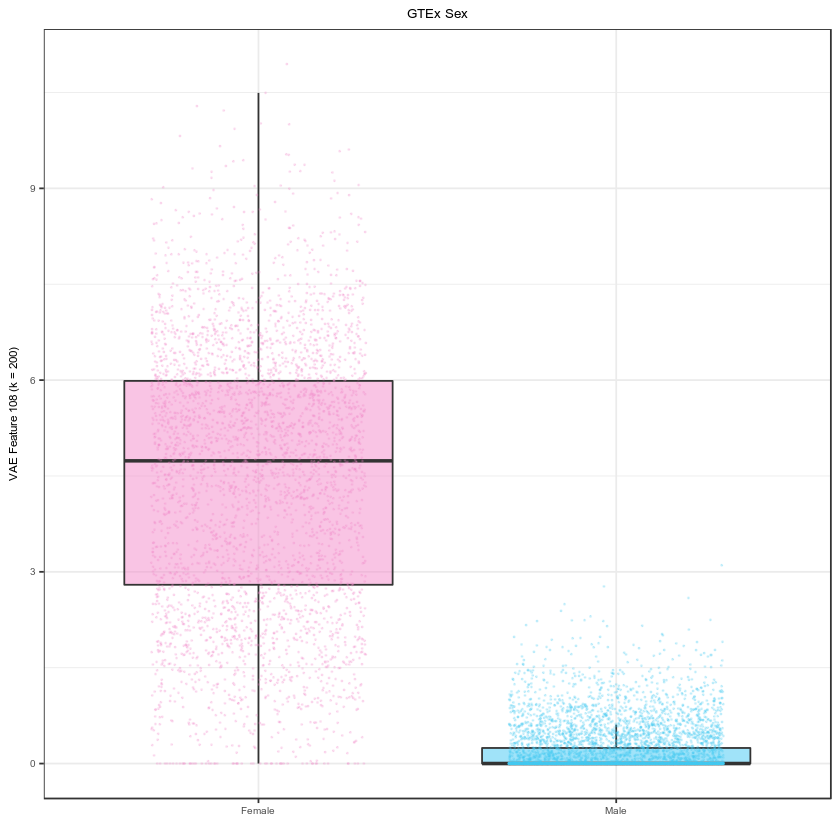

In [9]:
gtex_sex_gg <- ggplot(top_feature_df,
                      aes(y = vae_108,
                          x = SEX,
                          fill = SEX)) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = SEX),
              size = 0.2,
              alpha = 0.2,
              width = 0.3) +
  scale_fill_manual(labels = c("Male" = "Male",
                               "Female" = "Female"),
                    values = c("Male" = "#42c8f4",
                               "Female" = "#f489c9")) +
  scale_color_manual(labels = c("Male" = "Male",
                                "Female" = "Female"),
                     values = c("Male" = "#42c8f4",
                                "Female" = "#f489c9")) +
  theme_bw() +
  ylab("VAE Feature 108 (k = 200)") +
  xlab("") +
  ggtitle("GTEx Sex") +
  theme(axis.title.x = element_text(size = 7),
        axis.title.y = element_text(size = 7),
        axis.text.x = element_text(size = 6),
        axis.text.y = element_text(size = 6),
        plot.title = element_text(size = 8,
                                  hjust = 0.5),
        legend.position = "none")

gtex_sex_gg

## Plot TCGA Sex Example

In [10]:
# Load TCGA phenotype data
file <- file.path("..", "0.expression-download", "download", "TCGA-CDR-SupplementalTableS1.xlsx")
tcga_pheno_df <- readxl::read_xlsx(file, sheet=1)

head(tcga_pheno_df)

Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y1910 / R1910C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y1911 / R1911C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y1912 / R1912C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y1913 / R1913C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y1914 / R1914C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y1915 / R1915C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y1916 / R1916C25: got 'R0'”Warning message in read_fun

“Expecting logical in Y5440 / R5440C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5441 / R5441C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5442 / R5442C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5443 / R5443C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5444 / R5444C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5445 / R5445C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5446 / R5446C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5447

“Expecting logical in Y5499 / R5499C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5500 / R5500C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5501 / R5501C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5502 / R5502C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5503 / R5503C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5504 / R5504C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5505 / R5505C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5506

“Expecting logical in Y5558 / R5558C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5559 / R5559C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5560 / R5560C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5561 / R5561C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5562 / R5562C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5563 / R5563C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5564 / R5564C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5565

“Expecting logical in Y5617 / R5617C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5618 / R5618C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5619 / R5619C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5620 / R5620C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5621 / R5621C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5622 / R5622C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5623 / R5623C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5624

“Expecting logical in Y5676 / R5676C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5677 / R5677C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5678 / R5678C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5679 / R5679C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5680 / R5680C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5681 / R5681C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5682 / R5682C25: got '[Not Available]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting log

“Expecting logical in Y5735 / R5735C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5736 / R5736C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5737 / R5737C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5738 / R5738C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5739 / R5739C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5740 / R5740C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5741 / R5741C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5742

“Expecting logical in Y5794 / R5794C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5795 / R5795C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5796 / R5796C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5797 / R5797C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5798 / R5798C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5799 / R5799C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5800 / R5800C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y5801

“Expecting logical in Y6878 / R6878C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y6879 / R6879C25: got '[Not Available]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y6880 / R6880C25: got '[Unknown]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y6881 / R6881C25: got '[Not Available]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y6882 / R6882C25: got '[Unknown]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y6883 / R6883C25: got '[Unknown]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y6884 / R6884C25: got '[Unknown]'”Warning message in read_fun(path = path, sheet_i = sheet, limit

“Expecting logical in Y8557 / R8557C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8558 / R8558C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8559 / R8559C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8560 / R8560C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8561 / R8561C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8562 / R8562C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8563 / R8563C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8564

“Expecting logical in Y8616 / R8616C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8617 / R8617C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8618 / R8618C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8619 / R8619C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8620 / R8620C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8621 / R8621C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8622 / R8622C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8623

“Expecting logical in Y8675 / R8675C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8676 / R8676C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8677 / R8677C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8678 / R8678C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8679 / R8679C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8680 / R8680C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8681 / R8681C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8682

“Expecting logical in Y8734 / R8734C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8735 / R8735C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8736 / R8736C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8737 / R8737C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8738 / R8738C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8739 / R8739C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8740 / R8740C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8741

“Expecting logical in Y8793 / R8793C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8794 / R8794C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8795 / R8795C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8796 / R8796C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8797 / R8797C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y8798 / R8798C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9846 / R9846C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9847

“Expecting logical in Y9897 / R9897C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9898 / R9898C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9899 / R9899C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9900 / R9900C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9901 / R9901C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9902 / R9902C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9903 / R9903C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9904

“Expecting logical in Y9956 / R9956C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9957 / R9957C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9958 / R9958C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9959 / R9959C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9960 / R9960C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9961 / R9961C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9962 / R9962C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y9963

“Expecting logical in Y10015 / R10015C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10016 / R10016C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10017 / R10017C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10018 / R10018C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10019 / R10019C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10020 / R10020C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10021 / R10021C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting lo

“Expecting logical in Y10073 / R10073C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10074 / R10074C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10075 / R10075C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10076 / R10076C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10077 / R10077C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10078 / R10078C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10079 / R10079C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting lo

“Expecting logical in Y10131 / R10131C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10132 / R10132C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10133 / R10133C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10134 / R10134C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10135 / R10135C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10136 / R10136C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10137 / R10137C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting lo

“Expecting logical in Y10189 / R10189C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10190 / R10190C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10191 / R10191C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10192 / R10192C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10193 / R10193C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10194 / R10194C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10195 / R10195C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting lo

“Expecting logical in Y10247 / R10247C25: got 'R1'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10248 / R10248C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10249 / R10249C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10250 / R10250C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10251 / R10251C25: got 'R0'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10252 / R10252C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10253 / R10253C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting lo

“Expecting logical in Y10305 / R10305C25: got 'RX'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10306 / R10306C25: got '[Not Available]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10307 / R10307C25: got '[Not Available]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10308 / R10308C25: got '[Not Available]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10309 / R10309C25: got '[Not Available]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10310 / R10310C25: got '[Unknown]'”Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
“Expecting logical in Y10311 / R10311C25: got 'RX'”Warning message in read_fun(path = path, she

X__1,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,⋯,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
1,TCGA-OR-A5J1,ACC,58,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,1355,1,1355,1,754,1,754,NA
2,TCGA-OR-A5J2,ACC,44,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,1677,1,1677,NA,NA,1,289,NA
3,TCGA-OR-A5J3,ACC,23,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,0,2091,0,2091,1,53,1,53,NA
4,TCGA-OR-A5J4,ACC,23,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,423,1,423,NA,NA,1,126,NA
5,TCGA-OR-A5J5,ACC,30,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,365,1,365,NA,NA,1,50,NA
6,TCGA-OR-A5J6,ACC,29,FEMALE,BLACK OR AFRICAN AMERICAN,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,0,2703,0,2703,0,2703,0,2703,NA


In [11]:
best_k_dim <- paste(best_result_list[[t_test_results_files[3]]]$z_dim)
best_seed <- paste(best_result_list[[t_test_results_files[3]]]$seed)
best_feature <- paste0(paste(best_result_list[[t_test_results_files[3]]]$algorithm),
                       "_", 
                       paste(best_result_list[[t_test_results_files[3]]]$feature_num))

In [12]:
print(best_k_dim)
print(best_seed)
print(best_feature)

[1] "20"
[1] "486191"
[1] "vae_16"


In [13]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "TCGA_results",
                          "ensemble_z_matrices",
                          paste0("tcga_components_", best_k_dim),
                          paste0("model_", best_seed, "_z_matrix.tsv.gz"))

top_feature_df <- readr::read_tsv(feature_file,
                                  col_types = readr::cols(
                                    .default = readr::col_double(),
                                    sample_id = readr::col_character()
                                  )
) %>%
  dplyr::select(sample_id, !!best_feature)

head(top_feature_df)

sample_id,vae_16
TCGA-LL-A73Z-01,9.030849
TCGA-55-8207-01,3.677592
TCGA-FF-A7CR-01,0.000000
TCGA-BK-A13C-11,3.482272
TCGA-EB-A6L9-06,1.880454
TCGA-D8-A145-01,9.052761


In [14]:
dim(top_feature_df)

[1] 9954    2

In [15]:
full_tcga_ids <- c()
for (tcga_id in strsplit(top_feature_df$sample_id, "-")) {
  tcga_id_unlist <- unlist(tcga_id)
  sample_id <- paste0(tcga_id_unlist[1], "-", tcga_id_unlist[2], "-", tcga_id_unlist[3])
  full_tcga_ids <- c(full_tcga_ids, sample_id)
}

top_feature_df$tcga_id <- full_tcga_ids
top_feature_df <- top_feature_df %>%
  dplyr::left_join(tcga_pheno_df, by = c("tcga_id" = "bcr_patient_barcode"))

top_feature_df$gender[is.na(top_feature_df$gender)] <- "Unknown"
top_feature_df$gender <- dplyr::recode_factor(top_feature_df$gender, "MALE" = "Male", "FEMALE" = "Female")
top_feature_df$gender <- factor(top_feature_df$gender, levels = c("Female", "Male", "Unknown"))

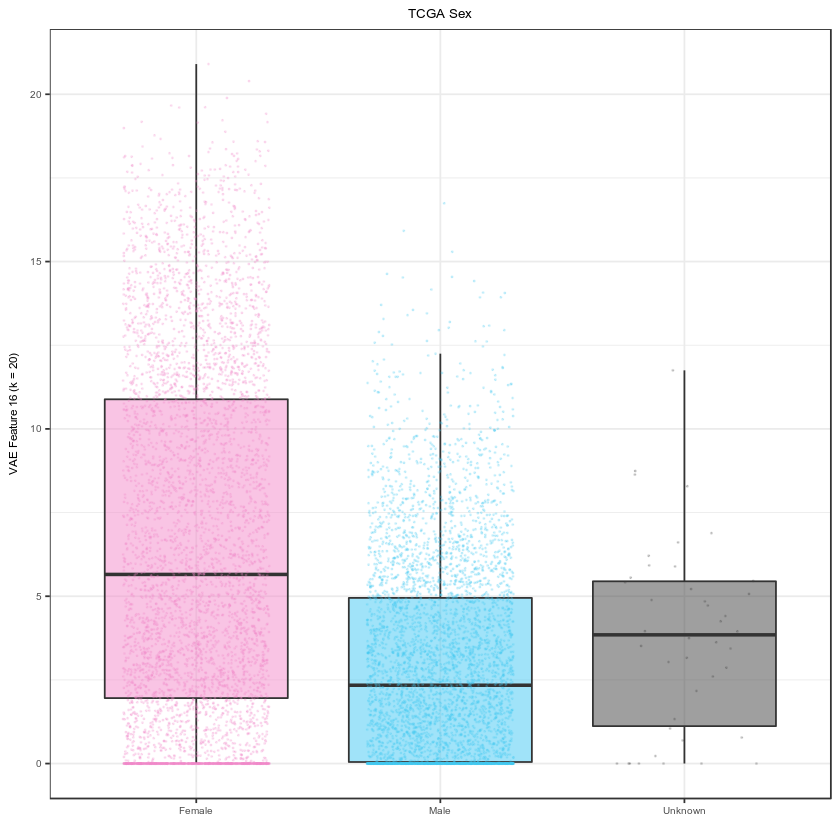

In [16]:
tcga_sex_gg <- ggplot(top_feature_df,
                      aes(y = vae_16,
                          x = gender,
                          fill = gender)) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = gender),
              size = 0.2,
              alpha = 0.2,
              width = 0.3) +
  scale_fill_manual(labels = c("Male" = "Male",
                               "Female" = "Female",
                               "Unknown" = "Unknown"),
                    values = c("Male" = "#42c8f4",
                               "Female" = "#f489c9",
                               "Unknown" = "grey25")) +
  scale_color_manual(labels = c("Male" = "Male",
                                "Female" = "Female",
                                "Unknown" = "Unknown"),
                     values = c("Male" = "#42c8f4",
                                "Female" = "#f489c9",
                                "Unknown" = "grey25")) +
  theme_bw() +
  ylab("VAE Feature 16 (k = 20)") +
  xlab("") +
  ggtitle("TCGA Sex") +
  theme(axis.title.x = element_text(size = 7),
        axis.title.y = element_text(size = 7),
        axis.text.x = element_text(size = 6),
        axis.text.y = element_text(size = 6),
        plot.title = element_text(size = 8,
                                  hjust = 0.5),
        legend.position = "none")

tcga_sex_gg

## Plot TARGET MYCN Amplification Results

In [17]:
best_k_dim <- paste(best_result_list[[t_test_results_files[1]]]$z_dim)
best_seed <- paste(best_result_list[[t_test_results_files[1]]]$seed)
best_feature <- paste0(paste(best_result_list[[t_test_results_files[1]]]$algorithm),
                       "_", 
                       paste(best_result_list[[t_test_results_files[1]]]$feature_num))

In [18]:
print(best_k_dim)
print(best_seed)
print(best_feature)

[1] "200"
[1] "451283"
[1] "vae_111"


In [19]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "TARGET_results",
                          "ensemble_z_matrices",
                          paste0("target_components_", best_k_dim),
                          paste0("model_", best_seed, "_z_matrix.tsv.gz"))

top_feature_df <- readr::read_tsv(feature_file,
                                  col_types = readr::cols(
                                    .default = readr::col_double(),
                                    sample_id = readr::col_character()
                                    )
                                  ) %>%
  dplyr::select(sample_id, !!best_feature)

In [20]:
# Load TARGET phenotype data
file <- file.path("..", "0.expression-download", "data", "2017-09-30-TARGET update harmonized.txt")
nbl_pheno_df <- readr::read_tsv(file)

full_target_ids <- c()
for (target_id in strsplit(top_feature_df$sample_id, "-")) {
  target_id_unlist <- unlist(target_id)
  full_target_ids <- c(full_target_ids, target_id_unlist[3])
}

top_feature_df$target_id <- full_target_ids
top_feature_df <- top_feature_df %>% 
  dplyr::inner_join(nbl_pheno_df, by = c("target_id" = "usi"))

Parsed with column specification:
cols(
  .default = col_character(),
  `Age at Diagnosis in Days` = col_integer(),
  `Event Free Survival Time in Days` = col_integer(),
  `Overall Survival Time in Days` = col_integer(),
  `Year of Diagnosis` = col_integer(),
  `Year of Last Follow Up` = col_integer(),
  `Ploidy Value` = col_double()
)
See spec(...) for full column specifications.


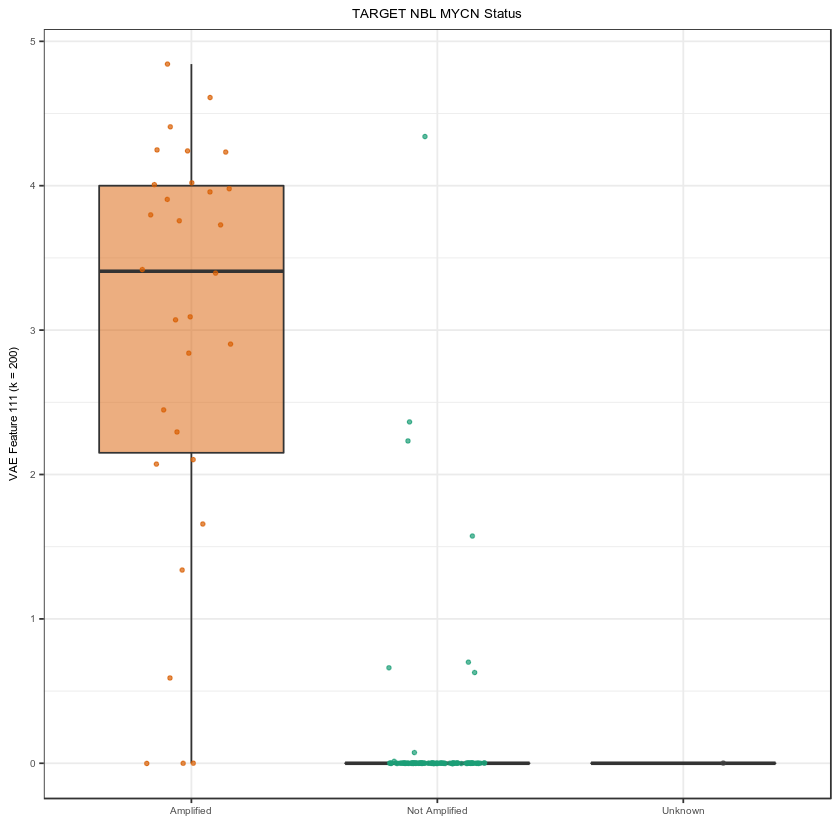

In [21]:
mycn_amp_gg <- ggplot(top_feature_df,
                      aes(y = vae_111,
                          x = `MYCN status`,
                          fill = `MYCN status`)) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = `MYCN status`),
              alpha = 0.7,
              size = 0.9,
              width = 0.2) +
  scale_fill_manual(labels = c("Amplified" = "Amplified",
                               "Not Amplified" = "Not Amplified",
                               "Unknown" = "Unknown"),
                    values = c("Amplified" = "#d95f02",
                               "Not Amplified" = "#1b9e77",
                               "Unknown" = "grey25")) +
  scale_color_manual(labels = c("Amplified" = "Amplified",
                                "Not Amplified" = "Not Amplified",
                                "Unknown" = "Unknown"),
                     values = c("Amplified" = "#d95f02",
                                "Not Amplified" = "#1b9e77",
                                "Unknown" = "grey25")) +
  theme_bw() +
  ylab("VAE Feature 111 (k = 200)") +
  xlab("") +
  ggtitle("TARGET NBL MYCN Status") +
  theme(axis.title.x = element_text(size = 7),
       axis.title.y = element_text(size = 7),
       axis.text.x = element_text(size = 6),
       axis.text.y = element_text(size = 6),
       plot.title = element_text(size = 8,
                                 hjust = 0.5),
       legend.position = "none")

mycn_amp_gg

## Plot MYCN Signature Applied to NBL Cell Lines

In [22]:
file <- file.path("results", "mycn_nbl_scores.tsv")
mycn_validation_df <- readr::read_tsv(file)

mycn_validation_df$`MYCN status` <- dplyr::recode_factor(mycn_validation_df$`MYCN status`,
                                                         "Non-amplified" = "Not Amplified")
mycn_validation_df$`MYCN status` <- factor(mycn_validation_df$`MYCN status`,
                                           levels = c("Amplified", "Not Amplified"))
head(mycn_validation_df)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  vae_111 = col_double(),
  `Cell Line` = col_character(),
  `MYCN status` = col_character(),
  `1p36 del` = col_character(),
  `3p26 del` = col_character(),
  `11q23 del` = col_character(),
  `17q21-qter unbal gain` = col_character(),
  `ALK mutation` = col_character(),
  `p53 mutation` = col_character()
)


X1,vae_111,Cell Line,MYCN status,1p36 del,3p26 del,11q23 del,17q21-qter unbal gain,ALK mutation,p53 mutation
0,6.253521,CHP134,Amplified,LOH p32.3-pter; Gain p34.3-p36.22; Loss p36.22-pter,Gain/AI p26.3,None,Gain q12-qter,WT,WT
1,3.720755,CHP212,Amplified,Loss p13.2-pter,Gain/AI p26.3,cnLOH 23.3,Gain q12-qter,WT,WT
2,4.658529,COGN415,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
3,5.322958,COGN440,Amplified,Unknown,Unknown,Unknown,Unknown,WT,WT
4,5.996785,COGN453,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
5,2.920578,COGN496,Amplified,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


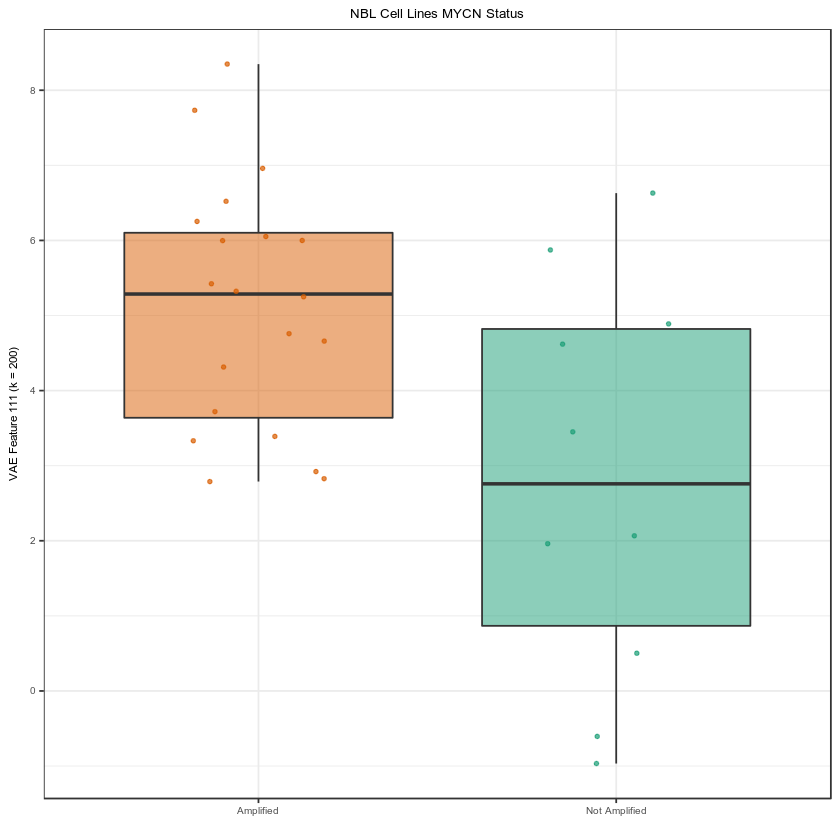

In [23]:
mycn_validation_gg <-
    ggplot(mycn_validation_df,
           aes(y = vae_111,
               x = `MYCN status`,
               fill = `MYCN status`)) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = `MYCN status`),
              alpha = 0.7,
              size = 0.9,
              width = 0.2) +
  theme_bw() +
  scale_fill_manual(labels = c("Amplified" = "Amplified",
                               "Not Amplified" = "Not Amplified"),
                    values = c("Amplified" = "#d95f02",
                               "Not Amplified" = "#1b9e77")) +
  scale_color_manual(labels = c("Amplified" = "Amplified",
                                "Not Amplified" = "Not Amplified"),
                     values = c("Amplified" = "#d95f02",
                                "Not Amplified" = "#1b9e77")) +
  ylab("VAE Feature 111 (k = 200)") +
  xlab("") +
  ggtitle("NBL Cell Lines MYCN Status") +
  theme(axis.title.x = element_text(size = 7),
       axis.title.y = element_text(size = 7),
       axis.text.x = element_text(size = 6),
       axis.text.y = element_text(size = 6),
       plot.title = element_text(size = 8,
                                 hjust = 0.5),
       legend.position = "none")

mycn_validation_gg

## Compile Plot

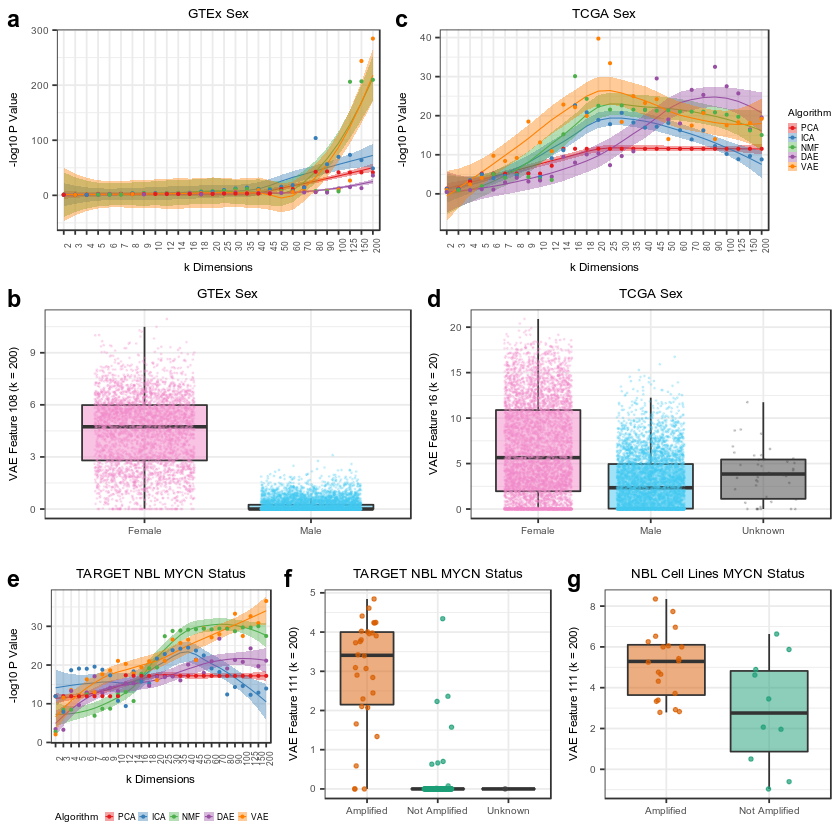

In [24]:
# Plot multi panel figure
line_gg_legend <- cowplot::get_legend(line_gg_list[[1]])

full_line_gg <- cowplot::plot_grid(
    line_gg_list[[2]] +
        theme(legend.position = "none") +
    ggtitle("GTEx Sex"),
        line_gg_list[[3]] +
    theme(legend.position = "none") +
        ggtitle("TCGA Sex"),
    labels = c("a", "c")
)

full_line_gg <- cowplot::plot_grid(full_line_gg,
                                   line_gg_legend,
                                   rel_widths = c(1, 0.08),
                                   ncol = 2)

box_gg <- cowplot::plot_grid(
    gtex_sex_gg,
    tcga_sex_gg,
    labels = c("b", "d"),
    ncol = 2
)


full_nbl_gg <- cowplot::plot_grid(
    line_gg_list[[1]] +
        ggtitle("TARGET NBL MYCN Status") +
        theme(legend.position = "bottom"),
    mycn_amp_gg +
        ggtitle("TARGET NBL MYCN Status"),
    mycn_validation_gg +
        ggtitle("NBL Cell Lines MYCN Status"),
    labels = c("e", "f", "g"),
    ncol = 3
)


main_plot <- cowplot::plot_grid(
    full_line_gg,
    box_gg,
    full_nbl_gg,
    nrow = 3
)

main_plot

In [25]:
for(extension in c('.png', '.pdf')) {
  fig_file <- paste0("full_separation_plot", extension)
  fig_file <- file.path("figures", fig_file)
  cowplot::save_plot(filename = fig_file,
                     plot = main_plot,
                     base_height = 180,
                     base_width = 170,
                     units = "mm")
}